In [72]:
in_path =r'../../data/clean/' # use your path
out_path=r'../../data/clean/'

import pandas as pd
pd.set_option('display.max_columns', 500)
import glob
import re
from nltk import stem
porter = stem.porter.PorterStemmer()
from gensim import corpora, models, similarities
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
    df=pd.read_csv(in_path+"articles.csv")   
    docs_csv=out_path+"docs.csv"
    df.AB.to_csv(docs_csv, index=False)
    
    with open(docs_csv) as f:
        docs = f.readlines()

In [74]:
    docs_prepared=out_path+'docs_prepared.csv'
    stop= open ('stopList.txt').read()
    stop_list = set(stop.replace("\n", " ").split())
    docs_cleaned = [[re.sub('[.!,;?()\W\d]+', '', word) for word in doc.lower().split()] for doc in docs]
    docs_stemed = [[porter.stem(word) for word in document if word not in stop_list] for document in docs_cleaned]
    with open(docs_prepared, 'w') as f:
        for doc in docs_stemed:f.write("%s\n" % ' '.join(doc))        

In [75]:
dictionary = corpora.Dictionary(docs_stemed)
dictionary.filter_extremes(no_below=5)
dictionary.compactify() 
print dictionary

class MyCorpus(object):
    def __iter__(self):
        for doc in docs_stemed:
            yield dictionary.doc2bow(doc)
corpus= MyCorpus() 
corpora.MmCorpus.serialize('deerwester.mm', corpus)
corpus = corpora.MmCorpus('deerwester.mm')
print corpus

Dictionary(2545 unique tokens: [u'', u'assimil', u'interchang', u'payoff', u'disappear']...)
MmCorpus(2101 documents, 2545 features, 123380 non-zero entries)


In [76]:
    tfidf = models.tfidfmodel.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=100) 
    corpus_lsi=lsi[corpus_tfidf]

    index = similarities.MatrixSimilarity(corpus_lsi) 
    lines = docs_stemed
    sims = open('..\csv\lsi.csv', 'w')
    sims.write('source,target,weight,type\n')
    for i in range(len(docs_stemed)):
        doc=lines[i]    
        vec_bow = dictionary.doc2bow(doc)
        vec_tran = lsi[tfidf[vec_bow]]
        #vec_tran = lda[tfidf[vec_bow]]
        simsinx = index[vec_tran]
        for j in range(i+1,len(simsinx)):
            if simsinx[j]>.4:                                        
                sims.write(str(i)+','+str(j)+','+str(simsinx[j])+',undirected\n')
    sims.close()

Traceback (most recent call last):
  File "C:\Users\moqri\AppData\Local\Continuum\Anaconda2\lib\logging\__init__.py", line 885, in emit
    self.flush()
  File "C:\Users\moqri\AppData\Local\Continuum\Anaconda2\lib\logging\__init__.py", line 845, in flush
    self.stream.flush()
IOError: [Errno 22] Invalid argument
Logged from file docsim.py, line 484


In [86]:
lsi_df=pd.read_csv('..\csv\lsi.csv')
lsi_df=lsi_df[lsi_df.weight>.5]
lsi_df.shape

(21621, 4)

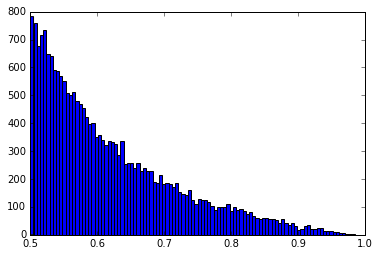

In [87]:
import numpy as np
l=lsi_df.weight
hist=plt.hist(l,101)

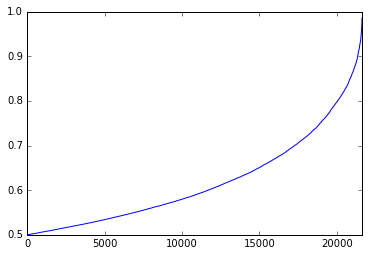

In [88]:
l=l.sort_values()
l=l.reset_index(drop=True)
l.plot(drawstyle='steps')

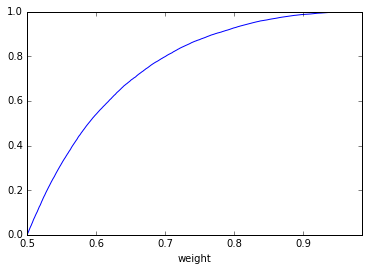

In [89]:
cum_dist = np.linspace(0.,1.,len(l))
cdf = pd.Series(cum_dist, index=l)
cdf.plot()

In [90]:
dic=cdf.to_dict()
lsi_df['p']=lsi_df.weight.apply(lambda x :1- dic[x])

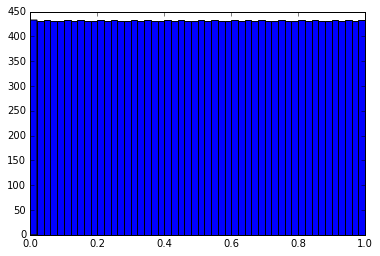

In [91]:
p=lsi_df.p
binwidth=.01
hist=plt.hist(p,50 )

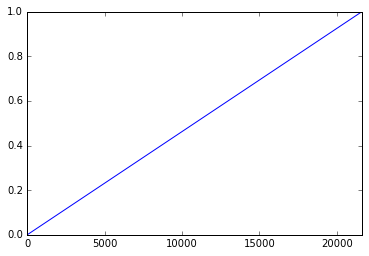

In [92]:
p=lsi_df.p
p=p.sort_values()
p=p.reset_index(drop=True)
p.plot(drawstyle='steps')

In [93]:
lsi_df['original_weight']=lsi_df.weight
lsi_df.drop('weight',inplace=True,axis=1)
lsi_df['weight']=1-lsi_df.p
lsi_df[['source','target','weight','type']].to_csv('..\csv\p_lsi.csv',index=False)

In [94]:
lsi_df.shape

(21621, 6)